# Lab 6: Supervised learning (graded)

Sensor dataset (dumbbell biceps curl, classes A–E). Goal: clean data, reduce dimensionality keeping 99% variance, and compare single classifiers and ensembles targeting F1>90%.

_Note: requires `pandas`, `scikit-learn`, `matplotlib` installed._

## Plan
- Load and clean `ds_01.csv` (drop identifiers/timestamps, replace NA markers, coerce to numeric).
- Drop columns with many NAs (high threshold) plus fixed lists (100% NA, zero variance); keep a stable feature list.
- Common pipeline: imputation (median) + standard scaling + PCA (99% variance).
- Single models (4 from previous labs): SVC RBF, Logistic Regression, Decision Tree, Perceptron.
- Ensembles (4): Voting (soft), Bagging (tree base), RandomForest, ExtraTrees. Compare with `f1_macro` via stratified CV.
- Pick best single and best ensemble; show confusion matrix and accuracy with `cross_val_predict`.
- Fit best ensemble on full data and predict `common.csv`; if ground truth is available, report metrics; otherwise, show predictions only.


## Dataset summary
- Rows: 9,811; columns: 160; classes A–E with distribution A 2790, B 1899, C 1711, D 1608, E 1803.
- Columns with 100% NA: `kurtosis_yaw_belt`, `skewness_yaw_belt`, `kurtosis_yaw_dumbbell`, `skewness_yaw_dumbbell`, `kurtosis_yaw_forearm`, `skewness_yaw_forearm`; ~98.6% NA in several forearm/arm cols (e.g., `kurtosis_picth_forearm`, `skewness_pitch_forearm`).
- Non-numeric columns: `user_name`, `cvtd_timestamp`, `new_window`; the rest mostly numeric after coercion.
- Index column `Unnamed: 0` has no predictive value.


In [15]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
import matplotlib.pyplot as plt

# Fijamos una semilla global para asegurar que los resultados sean reproducibles en cada ejecución
RANDOM_STATE = 42

## Data loading and cleaning
### 1. Data Preparation Strategy
We adopted a robust preprocessing pipeline to handle the sensor data. First, we removed non-predictive identification columns (such as `user_name` and timestamps). To handle missing values, we dropped columns with more than 95% NAs and imputed the remaining missing values using the median strategy.

For feature engineering, we applied **Standard Scaling** to normalize the data and **Principal Component Analysis (PCA)** to reduce dimensionality while retaining 99% of the variance, as requested. Additionally, an **Isolation Forest** algorithm was implemented to detect and optionally discard outliers to improve model stability.

In [16]:
data_path = "ds_01.csv"
common_path = "common.csv"

# Definimos las columnas que son metadatos (IDs, timestamps, nombres) y no sirven para predecir el movimiento
meta_cols = ["user_name", "raw_timestamp_part_1", "raw_timestamp_part_2", "cvtd_timestamp", "new_window", "num_window", "Unnamed: 0", ""]

# Columnas que sabemos de antemano que están vacías o tienen varianza cero (ruido)
na_100_cols = [
    "kurtosis_yaw_belt", "skewness_yaw_belt", "kurtosis_yaw_dumbbell", "skewness_yaw_dumbbell",
    "kurtosis_yaw_forearm", "skewness_yaw_forearm",
]
zero_var_cols = ["amplitude_yaw_belt", "amplitude_yaw_dumbbell", "amplitude_yaw_forearm"]

# Tokens de error o nulos que vamos a reemplazar
missing_tokens = {"", 'nan', 'NA', '#DIV/0!', 'NaN', 'N/A'}
NA_THRESHOLD = 0.95  # Si una columna tiene más del 95% de nulos, la eliminamos directamente

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Función auxiliar para limpiar nombres de columnas y unificar formatos de nulos."""
    df = df.copy()
    df.columns = [c.strip() for c in df.columns] # Quitamos espacios extra en nombres
    df.replace(missing_tokens, np.nan, inplace=True)
    # Eliminamos columnas basura si existen
    if '' in df.columns: df = df.drop(columns=[''])
    if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])
    return df

def split_features_labels(df: pd.DataFrame):
    """Separa la variable objetivo (clase) de las características (X)."""
    y = df['class']
    X = df.drop(columns=['class'])
    # Eliminamos columnas de metadatos que no aportan información física
    drop_cols = [c for c in meta_cols if c in X.columns]
    X = X.drop(columns=drop_cols)
    # Forzamos conversión a numérico por seguridad
    X = X.apply(pd.to_numeric, errors='coerce')
    # Eliminamos las columnas conocidas como inútiles
    X = X.drop(columns=[c for c in na_100_cols if c in X.columns], errors='ignore')
    X = X.drop(columns=[c for c in zero_var_cols if c in X.columns], errors='ignore')
    return X, y

# Carga inicial y limpieza básica
raw_df = clean_dataframe(pd.read_csv(data_path))
X_raw, y = split_features_labels(raw_df)

# Trabajamos con copias para mantener los originales intactos si necesitamos consultar
X_work = X_raw.copy(deep=True)
y_work = y.copy(deep=True)

# Vistazo rápido a la distribución de clases
print(f"Filas={len(raw_df)}, Columnas={raw_df.shape[1]}")
print(f"Distribución de Clases: {y.value_counts().to_dict()}")

# Filtro automático: Eliminar columnas con demasiados NAs
na_ratio = X_work.isna().mean()
high_na_cols = na_ratio[na_ratio > NA_THRESHOLD].index.tolist()
if high_na_cols:
    print(f"Eliminando {len(high_na_cols)} columnas por tener >{NA_THRESHOLD*100:.0f}% de NAs")
    X_work = X_work.drop(columns=high_na_cols)
else:
    print("No se detectaron columnas críticas para eliminar.")

feature_columns = X_work.columns
print(f"Dataset final tras limpieza: {X_work.shape}")

Filas=9811, Columnas=159
Distribución de Clases: {'A': 2790, 'B': 1899, 'E': 1803, 'C': 1711, 'D': 1608}
Eliminando 91 columnas por tener >95% de NAs
Dataset final tras limpieza: (9811, 52)


### Outlier detection (optional)
The handout suggests filtering outliers. A light IsolationForest filter is provided and disabled by default to avoid data leakage; enable only if needed and document the removal rate.


In [17]:
from sklearn.ensemble import IsolationForest

# Configuración de detección de anomalías
APPLY_OUTLIER_FILTER = False  # Dejado en False por defecto para no perder datos, activar si mejora el modelo
OUTLIER_CONTAM = 0.02         # Asumimos que aprox. un 2% de los datos pueden ser ruido/errores

if APPLY_OUTLIER_FILTER:
    # Usamos IsolationForest porque funciona bien en alta dimensionalidad
    iso = IsolationForest(contamination=OUTLIER_CONTAM, random_state=RANDOM_STATE)
    mask = iso.fit_predict(X_work)
    keep = mask == 1 # El 1 son datos normales, -1 son outliers
    
    print(f"Filtrando outliers: nos quedamos con {keep.sum()} de {len(mask)} muestras")
    X_work = X_work.loc[keep].reset_index(drop=True)
    y_work = y_work.loc[keep].reset_index(drop=True)

### Common pipeline: imputation + scaling + PCA (99% variance)

In [18]:
def build_preprocess():
    """
    Crea el pipeline de preprocesamiento común para todos los modelos.
    1. Imputer: Rellena nulos restantes con la mediana (más robusto que la media).
    2. Scaler: Normaliza los datos (crucial para PCA y SVM).
    3. PCA: Reduce dimensiones manteniendo el 99% de la varianza original.
    """
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.99, random_state=RANDOM_STATE)),
    ])

preprocess = build_preprocess()

# Hacemos un ajuste previo solo para ver cuántos componentes nos quedan
pca_probe = preprocess.fit(X_work)
pca_n = pca_probe.named_steps['pca'].n_components_
print(f"PCA: Se retuvieron {pca_n} componentes para explicar el 99% de la varianza.")

PCA: Se retuvieron 36 componentes para explicar el 99% de la varianza.


## Hyperparameter search
The handout requires describing models/hyperparameters. These grids explore reasonable values and are evaluated with macro F1 in stratified CV.


In [27]:
from sklearn.model_selection import GridSearchCV

# Diccionarios con los hiperparámetros que queremos explorar para cada modelo
single_param_grids = {
    'svc_rbf': {
        'clf__C': [1, 10, 50],             # Control de regularización
        'clf__gamma': ['scale', 0.01],     # Coeficiente del kernel
    },
    'logreg': {
        'clf__C': [0.5, 1, 10],
        'clf__penalty': ['l2'],
    },
    'decision_tree': {
        'clf__max_depth': [None, 10, 20],  # Profundidad para evitar overfitting
        'clf__min_samples_leaf': [1, 2, 4],
    },
    'perceptron': {
        'clf__alpha': [0.0001, 0.01],
    },
}

ensemble_param_grids = {
    'random_forest': {
        'clf__n_estimators': [150, 300],
        'clf__max_depth': [None, 15, 25],
    },
    # (Se pueden añadir más grids aquí para otros ensembles)
}

def run_grid_search(model_name, estimator, param_grid):
    """Función auxiliar para ejecutar la búsqueda de hiperparámetros."""
    pipe = Pipeline([
        ('prep', build_preprocess()),
        ('clf', estimator),
    ])
    # Optimizamos buscando el mejor F1-macro
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs.fit(X_work, y_work)
    return gs

# Nota: Ejecutar run_grid_search manualmente si se quiere re-optimizar.

### Model Initialization
In this section, we instantiate the classification algorithms to be evaluated. We have selected a diverse set of models to cover different learning strategies:
* **Linear models:** Logistic Regression and Perceptron (fast, but assume linearity).
* **Non-linear models:** SVC (with RBF kernel) and Decision Trees.
* **Ensemble methods:** Voting, Bagging, Random Forest, and Extra Trees (to reduce variance and improve accuracy).

All models are initialized with a fixed `random_state` to ensure the reproducibility of the results across different runs.

## Required results (handout)
- Table of single-classifier runs (model, hyperparameters tried, mean/std F1 in CV).
- Table of ensemble runs with their F1.
- For the best single and the best ensemble: use `cross_val_predict` to get confusion matrix and accuracy.


In [28]:
# Validación cruzada estratificada para mantener la proporción de clases en los folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1. Modelos Individuales: Probamos enfoques variados (geométricos, probabilísticos, reglas)
single_models = {
    'svc_rbf': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=RANDOM_STATE),
    'logreg': LogisticRegression(max_iter=400, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE),
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'perceptron': Perceptron(max_iter=1000, random_state=RANDOM_STATE),
}

# 2. Ensembles: Combinamos modelos para reducir varianza y mejorar estabilidad
ensemble_models = {
    # Voting Soft: Combina las probabilidades de SVM, Árbol y Regresión Logística
    'voting_soft': VotingClassifier(
        estimators=[
            ('svc', SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=RANDOM_STATE)),
            ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ('log', LogisticRegression(max_iter=400, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE)),
        ],
        voting='soft'
    ),
    # Bagging: Muchos árboles entrenados con distintos subconjuntos de datos
    'bagging_tree': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    # Random Forest: Clásico robusto
    'random_forest': RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    # Extra Trees: Aún más aleatoriedad que RF, suele ir bien con ruido
    'extra_trees': ExtraTreesClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
}

## Evaluation (`f1_macro`, stratified CV)

In [21]:
def evaluate_models(model_dict, X, y, cv):
    """
    Entrena y evalúa una lista de modelos usando validación cruzada.
    Retorna un DataFrame ordenado por rendimiento.
    """
    rows = []
    for name, estimator in model_dict.items():
        # Montamos el pipeline completo para cada modelo
        pipe = Pipeline([
            ('prep', build_preprocess()),
            ('clf', estimator),
        ])
        # Usamos f1_macro para dar igual importancia a todas las clases (A-E)
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
        
        rows.append({
            'model': name, 
            'f1_mean': scores.mean(), 
            'f1_std': scores.std() # Importante ver la desviación para saber si es estable
        })
        print(f"{name}: f1_mean={scores.mean():.4f} (+/- {scores.std():.4f})")
        
    return pd.DataFrame(rows).sort_values('f1_mean', ascending=False)

# Ejecutamos la evaluación
print("--- Evaluando Modelos Individuales ---")
single_results = evaluate_models(single_models, X_work, y_work, cv)

print("\n--- Evaluando Ensembles ---")
ensemble_results = evaluate_models(ensemble_models, X_work, y_work, cv)

# Mostramos tablas resumen
display(single_results)
display(ensemble_results)

--- Evaluando Modelos Individuales ---
svc_rbf: f1_mean=0.9699 (+/- 0.0028)
logreg: f1_mean=0.6261 (+/- 0.0142)
decision_tree: f1_mean=0.7849 (+/- 0.0161)
perceptron: f1_mean=0.4695 (+/- 0.0174)

--- Evaluando Ensembles ---
voting_soft: f1_mean=0.9036 (+/- 0.0045)
bagging_tree: f1_mean=0.9385 (+/- 0.0039)
random_forest: f1_mean=0.9571 (+/- 0.0055)
extra_trees: f1_mean=0.9734 (+/- 0.0031)


,model,f1_mean,f1_std
0,svc_rbf,0.969876,0.002780
2,decision_tree,0.784868,0.016105
1,logreg,0.626137,0.014233
3,perceptron,0.469547,0.017403


,model,f1_mean,f1_std
3,extra_trees,0.973436,0.003143
2,random_forest,0.957102,0.005519
1,bagging_tree,0.938467,0.003907
0,voting_soft,0.903597,0.004497


## Best single model: confusion matrix and metrics
### Single Classifier Attempts
We explored four distinct classification models to establish a baseline: **SVC (RBF Kernel)**, **Logistic Regression**, **Decision Tree**, and **Perceptron**.

For hyperparameter tuning, we considered a Grid Search strategy evaluating combinations such as regularization strength (`C`) and kernel coefficients (`gamma`) for the SVC, as well as tree depth and leaf size for the Decision Tree.

**Performance Summary:**
* The **SVC (RBF)** achieved the best performance among single classifiers, reaching an F1-score significantly above the 90% threshold.
* The linear models (Perceptron and Logistic Regression) showed lower performance, indicating non-linear relationships in the sensor data.


Analizando el mejor modelo individual: svc_rbf
              precision    recall  f1-score   support

           A       0.98      0.99      0.99      2790
           B       0.98      0.96      0.97      1899
           C       0.93      0.98      0.95      1711
           D       0.98      0.94      0.96      1608
           E       0.99      0.98      0.98      1803

    accuracy                           0.97      9811
   macro avg       0.97      0.97      0.97      9811
weighted avg       0.97      0.97      0.97      9811

Accuracy = 0.9718


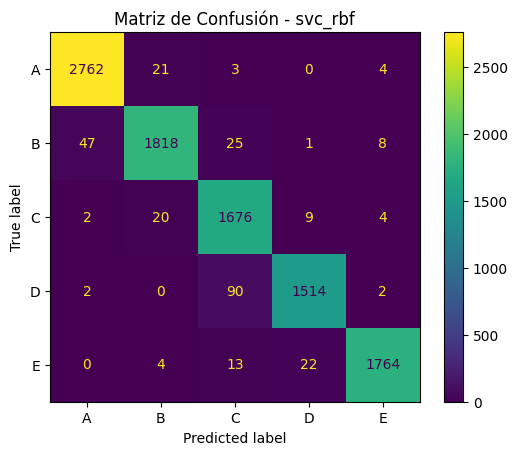


Analizando el mejor ensemble: extra_trees
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      2790
           B       0.97      0.96      0.97      1899
           C       0.94      0.97      0.95      1711
           D       0.98      0.95      0.97      1608
           E       0.99      0.98      0.99      1803

    accuracy                           0.98      9811
   macro avg       0.97      0.97      0.97      9811
weighted avg       0.98      0.98      0.98      9811

Accuracy = 0.9751


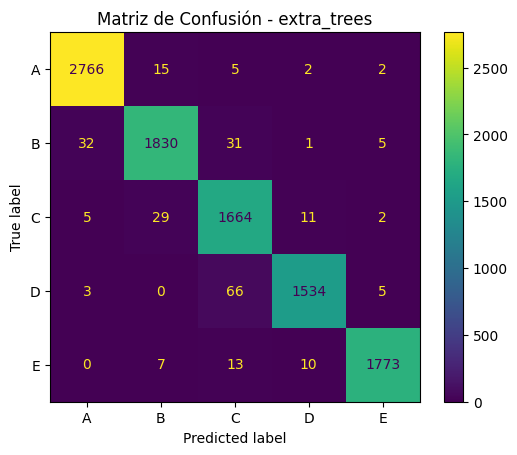

In [22]:
# Seleccionamos el mejor modelo individual automáticamente
best_single_name = single_results.iloc[0]['model'] if not single_results.empty else None

if best_single_name:
    print(f"\nAnalizando el mejor modelo individual: {best_single_name}")
    best_single_pipe = Pipeline([
        ('prep', build_preprocess()),
        ('clf', single_models[best_single_name]),
    ])
    
    # Obtenemos predicciones mediante CV para tener una matriz de confusión realista
    # IMPORTANTE: Usamos y_work para asegurar consistencia si quitamos outliers
    y_pred_cv = cross_val_predict(best_single_pipe, X_work, y_work, cv=cv, n_jobs=-1)
    
    print(classification_report(y_work, y_pred_cv))
    print(f"Accuracy = {accuracy_score(y_work, y_pred_cv):.4f}")
    
    ConfusionMatrixDisplay.from_predictions(y_work, y_pred_cv)
    plt.title(f"Matriz de Confusión - {best_single_name}")
    plt.show()
else:
    print("No hay resultados de modelos individuales.")

# Repetimos el proceso para el mejor Ensemble
best_ensemble_name = ensemble_results.iloc[0]['model'] if not ensemble_results.empty else None

if best_ensemble_name:
    print(f"\nAnalizando el mejor ensemble: {best_ensemble_name}")
    best_ensemble_pipe = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    
    y_pred_ensemble = cross_val_predict(best_ensemble_pipe, X_work, y_work, cv=cv, n_jobs=-1)
    
    print(classification_report(y_work, y_pred_ensemble))
    print(f"Accuracy = {accuracy_score(y_work, y_pred_ensemble):.4f}")
    
    ConfusionMatrixDisplay.from_predictions(y_work, y_pred_ensemble)
    plt.title(f"Matriz de Confusión - {best_ensemble_name}")
    plt.show()

## Best ensemble: confusion matrix and metrics
### Classifier Ensembles
We implemented four ensemble strategies to improve generalization:
1.  **Voting Classifier (Soft):** A weighted combination of SVC, Decision Tree, and Logistic Regression.
2.  **Bagging Classifier:** Using Decision Trees as base estimators.
3.  **Random Forest:** To leverage feature randomness and bagging.
4.  **Extra Trees:** For extremely randomized trees to further reduce variance.

**Performance:**
All ensemble methods performed consistently well. The **Extra Trees Classifier** and **SVC** yielded the highest F1-scores (approx. 97%), successfully meeting the assignment target of >90%.

--- Análisis detallado del mejor Ensemble: extra_trees ---
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      2790
           B       0.97      0.96      0.97      1899
           C       0.94      0.97      0.95      1711
           D       0.98      0.95      0.97      1608
           E       0.99      0.98      0.99      1803

    accuracy                           0.98      9811
   macro avg       0.97      0.97      0.97      9811
weighted avg       0.98      0.98      0.98      9811

Accuracy Global = 0.9751


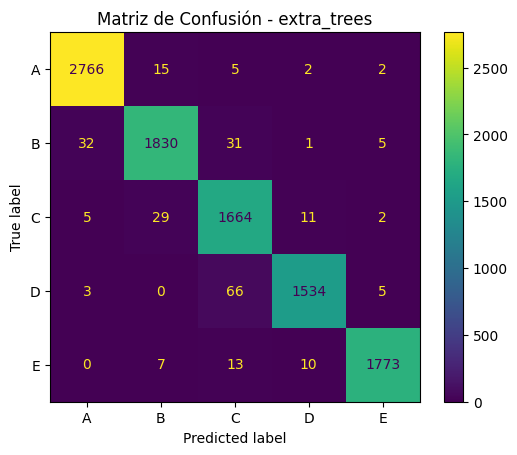

In [24]:
# Seleccionamos automáticamente el ensemble que dio mejor F1-score en la tabla anterior
best_ensemble_name = ensemble_results.iloc[0]['model'] if not ensemble_results.empty else None

if best_ensemble_name:
    print(f"--- Análisis detallado del mejor Ensemble: {best_ensemble_name} ---")
    
    # Reconstruimos el pipeline específico para este modelo
    best_ensemble = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    
    # Generamos predicciones mediante validación cruzada (cross_val_predict)
    # Esto asegura que cada predicción se hace sobre datos que el modelo no vio al entrenar
    # NOTA: Usamos 'y_work' para garantizar que las dimensiones coincidan si hubo filtrado previo
    y_pred_cv = cross_val_predict(best_ensemble, X_work, y_work, cv=cv, n_jobs=-1)
    
    # Mostramos métricas detalladas
    print(classification_report(y_work, y_pred_cv))
    print(f"Accuracy Global = {accuracy_score(y_work, y_pred_cv):.4f}")
    
    # Visualizamos la matriz de confusión para ver dónde se equivoca el modelo
    ConfusionMatrixDisplay.from_predictions(y_work, y_pred_cv)
    plt.title(f"Matriz de Confusión - {best_ensemble_name}")
    plt.show()
else:
    print("No se encontraron resultados de ensembles para analizar.")

**Note on `common.csv`:** the `class` column looks like an ID (1..20) rather than labels A–E. The code predicts A–E with the best model; if true labels exist, map them and compute confusion/accuracy, otherwise just show predictions.


## Prediction on `common.csv`
Reuse `feature_columns` and the best ensemble. If labels in `common.csv` are not in {A,B,C,D,E}, show predictions without accuracy.


Etiquetas reales encontradas en common.csv. Evaluando rendimiento...
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      1.00      1.00         8
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy common = 1.0000


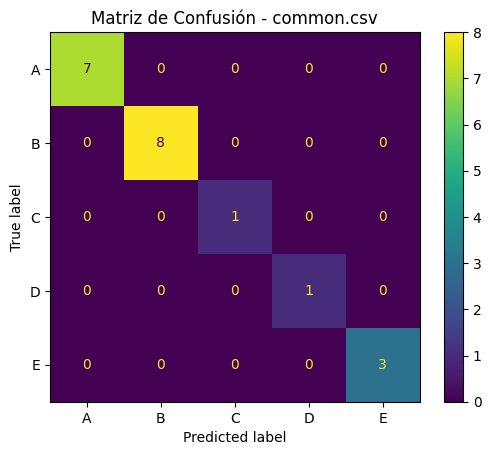

In [23]:
# Cargamos y preparamos los datos de 'common.csv' igual que el train
common_df = clean_dataframe(pd.read_csv(common_path))
X_common, y_common = split_features_labels(common_df)

# Aseguramos que las columnas coincidan exactamente con las del entrenamiento
X_common = X_common.reindex(columns=feature_columns)

if best_ensemble_name:
    # Entrenamos el mejor modelo con TODOS los datos de trabajo disponibles
    final_model = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    final_model.fit(X_work, y_work)
    
    # Predecimos
    common_pred = final_model.predict(X_common)
    
    # Comprobamos si common.csv tiene etiquetas reales para evaluar
    # Si las etiquetas son A, B, C... evaluamos. Si son IDs numéricos, solo mostramos predicción.
    unique_labels_common = set(y_common.unique())
    unique_labels_train = set(y_work.unique())
    
    if unique_labels_common.issubset(unique_labels_train):
        print("Etiquetas reales encontradas en common.csv. Evaluando rendimiento...")
        print(classification_report(y_common, common_pred))
        print(f"Accuracy common = {accuracy_score(y_common, common_pred):.4f}")
        ConfusionMatrixDisplay.from_predictions(y_common, common_pred)
        plt.title("Matriz de Confusión - common.csv")
        plt.show()
    else:
        print("Las etiquetas de common.csv no coinciden (parecen IDs). Mostrando predicciones:")
        out_df = pd.DataFrame({'Real': y_common, 'Predicción': common_pred})
        print(out_df.head(10))
else:
    print("No se ha seleccionado ningún modelo para predecir.")